# Analyse the different train/test period experiments

In [28]:
# !pip install netcdf4

In [29]:
# !conda install -c conda-forge shap==0.30

In [30]:
# !conda update matplotlib

In [31]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [32]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [33]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

# Get all experiment files

In [360]:
features = [d for d in (data_dir / 'features/').glob('2020*TR*')]
features.sort()
model_dirs = [d for d in (data_dir / 'models/').glob('2020*TR*')]
model_dirs.sort()

print(f"No. Driving Data:  {len(features)}")
print(f"No. Modelled Data: {len(model_dirs)}")

print(features[0])
print(model_dirs[0])

No. Driving Data:  27
No. Modelled Data: 27
data/features/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51
data/models/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51


In [361]:
# get parameters for experiments
test_length = 12
pred_timesteps = 3

train_hilos = [m.name.split('_')[-3][2:] for m in model_dirs]
test_hilos = [m.name.split('_')[-2][2:] for m in model_dirs]
train_lengths = [int(m.name.split('_')[-1][3:]) for m in model_dirs]

In [362]:
from pandas.tseries.offsets import MonthEnd

# GET TEST TIMES
test_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('preds_')[-1].replace('.nc', '').split('_'))) + MonthEnd(1)
        for d in (model / 'ealstm').glob('*.nc')
    ])
    for model in model_dirs
]

test_times2 = [
    np.array([
        pd.to_datetime('-'.join(dir_.name.split('_'))) + MonthEnd(1)
        for dir_ in (feature / 'test').iterdir() if dir_.name != 'ERROR'
    ])
    for feature in features
]

# GET TRAIN TIMES
train_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'train').iterdir()
    ])
    for feature in features
]

# check no. test timesteps is 
# assert all([test_length == len(tt) for tt in test_times2])

# check no. train timesteps are equivalent
assert all([np.isclose(train_lengths[i], len(train_times[i]), atol=15) for i in range(len(train_times))])

print(train_lengths)
print([len(train_times[i]) for i in range(len(train_times))])

# TODO: why is the number of model preds.nc objects different?
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

[51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153]
[51, 114, 154, 51, 114, 154, 51, 113, 153, 51, 114, 153, 51, 113, 154, 51, 110, 154, 51, 115, 155, 51, 112, 153, 51, 114, 156]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


## Rebuild experiment objects

In [363]:
from scripts.experiments.experiment import Experiment

In [380]:
sorted_timesteps = pd.date_range('2002-01-01', '2019-01-01', freq='M')
all_experiments = {}
for (
    train_hilo, test_hilo, train_timesteps, test_timesteps, train_length
) in zip(train_hilos, test_hilos, train_times, test_times2, train_lengths):
    
    expt_name = f"one_month_forecast_TR{train_hilo}_TE{test_hilo}_LEN{train_length}"
    e = Experiment(
        train_length=train_length,
        train_hilo=train_hilo,
        test_hilo=test_hilo,
        test_length=12,
        sorted_timesteps=sorted_timesteps,
        pred_timesteps = 3,
    )
    e.train_timesteps = train_timesteps
    e.test_timesteps = test_timesteps
    
    all_experiments[expt_name] = e

one_month_forecast_TRmed_TEhigh_LEN153


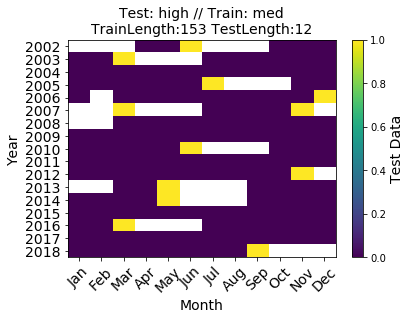

In [381]:
experiment = [k for k in all_experiments.keys()][11]
print(experiment)
# print(dir(all_experiments['one_month_forecast_TRhigh_TEhigh_LEN51']))

fig, ax = plt.subplots()
all_experiments[experiment].plot_experiment_split(ax=ax)
# all_experiments[experiment].test_timesteps

# Load in the data

In [53]:
# Experiment names
experiments = [d.name for d in model_dirs]
true_data_experiments = [d.name for d in features]

TARGET_VAR = 'boku_VCI'

# check the experiments are aligned properly
assert all(
    [
        '_'.join(experiments[i].split('_')[3:]) == '_'.join(true_data_experiments[i].split('_')[3:])
        for i in range(len(experiments))
    ]
)

In [54]:
print('_'.join(experiments[0].split('_')[3:]))
print('_'.join(true_data_experiments[0].split('_')[3:]))

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN51


In [55]:
from src.utils import get_ds_mask

X_train, _ = read_train_data(data_dir, experiment=true_data_experiments[0])
mask = get_ds_mask(X_train.VCI)

In [59]:
import pickle

# ONLY RUN IF DATA NOT SAVED!
if False:# (data_dir / 'tommy/obs_dict.pkl').exists() and (data_dir / 'tommy/model_dict.pkl').exists():
    obs_dict = pickle.load(open(data_dir / 'tommy/obs_dict.pkl', 'rb'))
    model_dict = pickle.load(open(data_dir / 'tommy/model_dict.pkl', 'rb'))
else:
    obs_dict = {}
    model_dict = {}

    for TRUE_EXPERIMENT, EXPERIMENT in zip(true_data_experiments, experiments):
        expt_name = '_'.join(EXPERIMENT.split('_')[3:])
        obs_dict[expt_name] = {}
        model_dict[expt_name] = {}

        # get the observed X, y data
        X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
        X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)

        obs_dict[expt_name]['X_train'] = X_train
        obs_dict[expt_name]['y_train'] = y_train
        obs_dict[expt_name]['X_test'] = X_test
        obs_dict[expt_name]['y_test'] = y_test

        # Get the model predictions
        lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

        model_dict[expt_name]['lstm_pred'] = lstm_pred
        model_dict[expt_name]['bline_pred'] = bline_pred
        model_dict[expt_name]['ealstm_pred'] = ealstm_pred

    
    print(f'Saving to {data_dir / "tommy"}')
    with open(data_dir / 'tommy/obs_dict.pkl', 'wb') as fp:
        pickle.dump(obs_dict, fp)
    with open(data_dir / 'tommy/model_dict.pkl', 'wb') as fp:
        pickle.dump(model_dict, fp)

print('** DONE! **')

Saving to data/tommy
** DONE! **


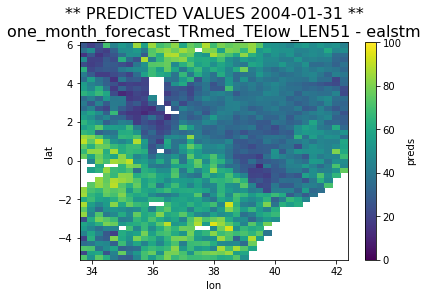

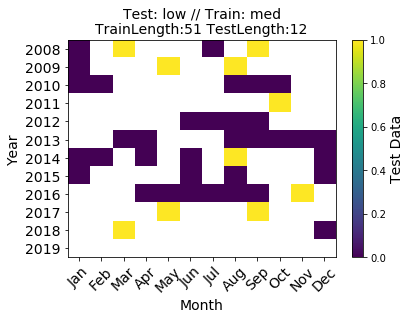

In [57]:
fig, ax = plt.subplots()
time_ix = 1
kwargs = dict(vmin=0, vmax=100, cmap='viridis')

experiment_name = [k for k in model_dict.keys()][-12]
time = model_dict[experiment_name]['ealstm_pred'].time.values
model_dict[experiment_name]['ealstm_pred'].isel(time=time_ix).plot(ax=ax, **kwargs)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0][2:]} **\n{experiment_name} - ealstm", size=16);

all_experiments[experiment_name].plot_experiment_split()

## Clean up the missing/extra preds (TODO: WHY?)

In [45]:
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [46]:
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

if False:
    # which datetimes are missing / extra?
    # GET TEST TIMES
    model_test_dirs = [
        np.array([
            d.name.split('preds_')[-1].replace('.nc', '')
            for d in (model / 'ealstm').glob('*.nc')
        ])
        for model in model_dirs
    ]

    obs_test_dirs = [
        np.array([
            d.name
            for d in (feature / 'test').iterdir()
        ])
        for feature in features
    ]
    # sort the files
    [a.sort() for a in model_test_dirs]
    [a.sort() for a in obs_test_dirs]

    # WHICH EXPERIMENTS HAVE ISSUES WITH NUMBER OF PREDS?
    bool_have_issue = [len(model_test_dirs[i]) != len(obs_test_dirs[i]) for i in range(len(model_test_dirs))]
    model_dirs_with_issues = np.array(model_dirs)[bool_have_issue]
    obs_dirs_with_issues = np.array(features)[bool_have_issue]

    # create a dictionary of EXPERIMENT NAME -> valid preds (obs)
    expts_with_issues = [d.name for d in model_dirs_with_issues]
    valid_obs_test_timesteps = [[d.name for d in list(dir_.glob('test/*'))] for dir_ in obs_dirs_with_issues]
    model_valid_timesteps_lookup = dict(zip(expts_with_issues, valid_obs_test_timesteps))

    expts_with_issues = [d.name for d in model_dirs_with_issues]
    valid_model_test_timesteps = [
        np.unique(
            [d.name.split('preds_')[-1].replace('.nc', '') for d in list(dir_.glob('**/**/*.nc'))]
        ) 
        for dir_ in model_dirs_with_issues
    ]
    obs_valid_timesteps_lookup = dict(zip(expts_with_issues, valid_model_test_timesteps))

    # Two possibilities:
    # a) too many preds in the model dirs (in model but not obs)
    # b) too few preds in the model dirs (in obs but not model)

    ## -------- MODELS -------- ##
    # Create a dataframe (easier to visualise/work with)
    a = [list(parent_d.glob('**/*.nc')) for parent_d in model_dirs_with_issues]
    all_array = np.array([])
    all_array = np.append(all_array, a[0])
    all_array = np.append(all_array, a[1])
    all_array = np.append(all_array, a[2])
    model_names = [d.parents[0].name for d in all_array]
    experiment_names = [d.parents[1].name for d in all_array]
    all_times = [d.name.split('preds_')[-1].replace('.nc', '') for d in all_array]

    model_dirs_df = pd.DataFrame({
        'experiment': experiment_names,
        'model': model_names,
        'path': all_array,
        'time': all_times,
    })
    model_dirs_df['is_valid'] = model_dirs_df.apply(lambda row: row.time in model_valid_timesteps_lookup[row.experiment], axis=1)


    ## -------- OBSERVATIONS -------- ##
    obs_dirs_with_issues = np.array(features)[bool_have_issue]
    a = [list(parent_d.glob('test/*')) for parent_d in obs_dirs_with_issues]
    all_array = np.array([])
    all_array = np.append(all_array, a[0])
    all_array = np.append(all_array, a[1])
    all_array = np.append(all_array, a[2])
    experiment_names = [d.parents[1].name for d in all_array]
    all_times = [d.name for d in all_array]
    obs_dirs_df = pd.DataFrame({
        'experiment': experiment_names,
        'path': all_array,
        'time': all_times,
    })
    obs_dirs_df['is_valid'] = obs_dirs_df.apply(lambda row: row.time in obs_valid_timesteps_lookup[row.experiment], axis=1)

    display(model_dirs_df.head())
    display(obs_dirs_df.head())

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [47]:
import shutil


def move_model_path(file_path: Path) -> None:
    error_dir = (file_path.parents[0] / 'ERROR')
    # MAKE Error Direcory
    if not error_dir.exists():
        error_dir.mkdir(exist_ok=True, parents=False)

    # DEFINE the to path
    to_path = error_dir / file_path.name
    # MOVE the file
    shutil.move((file_path).as_posix(), (to_path).as_posix())
    print(f"Moved: {file_path} to {to_path}")


if False:
    ### Move the invalid paths to a new location
    models_to_move = model_dirs_df.loc[~model_dirs_df.is_valid]
    obs_to_move = obs_dirs_df.loc[~obs_dirs_df.is_valid]

    for file_path in models_to_move.path:
        move_model_path(file_path)

    for file_path in obs_to_move.path:
        move_model_path(file_path)


# Model Performance Scores

### Pixel wise performance

In [48]:
# how many preds in each 
[d for d in model_dirs[0].iterdir()]

print([len(a) for a in test_times])
print([len(a) for a in test_times2])

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [66]:
from src.analysis import spatial_rmse, spatial_r2

rmse_dict = {}
r2_dict = {}
mean_performances = {}

for experiment_name in [k for k in model_dict.keys()]:
    print(experiment_name)
    rmse_dict[experiment_name] = {}
    r2_dict[experiment_name] = {}
    
    # iterate over each model defined for that experiment
    models = [k for k in model_dict[experiment_name].keys()]
    
    for model in models:
        obs = obs_dict[experiment_name]['y_test'][TARGET_VAR].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        preds = model_dict[experiment_name][model].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        
        # ONLY SELECT MATCHING TIMES (Why are there errors here anyway?)
        preds = preds.sel(time=np.isin(preds.time, obs.time))
        obs = obs.sel(time=np.isin(obs.time, preds.time))

        # ------- RMSE -------
        model_rmse = spatial_rmse(
            obs, preds
        )
        rmse_dict[experiment_name][model] = model_rmse
        
        # ------- R2 -------
        model_r2 = spatial_r2(
            obs, preds
        )
        r2_dict[experiment_name][model] = model_r2

        # calculate mean performance scores
        model_mean_rmse = model_rmse.mean().values
#         print(f"{experiment_name} {model} mean RMSE: ".ljust(20), f"{model_mean:.2f}")
        model_mean_r2 = model_r2.mean().values
#         print(f"{experiment_name} {model} mean R2: ".ljust(20), f"{model_mean:.2f}")
        
        # build mean performance dictionaries
        mean_performances[experiment_name] = {}
        mean_performances[experiment_name][model] = {}
        mean_performances[experiment_name][model]['rmse'] = model_mean_rmse
        mean_performances[experiment_name][model]['r2'] = model_mean_r2

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN102
one_month_forecast_TRhigh_TEhigh_LEN153
one_month_forecast_TRhigh_TEmed_LEN51
one_month_forecast_TRhigh_TEmed_LEN102
one_month_forecast_TRhigh_TEmed_LEN153
one_month_forecast_TRhigh_TElow_LEN51
one_month_forecast_TRhigh_TElow_LEN102
one_month_forecast_TRhigh_TElow_LEN153
one_month_forecast_TRmed_TEhigh_LEN51
one_month_forecast_TRmed_TEhigh_LEN102
one_month_forecast_TRmed_TEhigh_LEN153
one_month_forecast_TRmed_TEmed_LEN51
one_month_forecast_TRmed_TEmed_LEN102
one_month_forecast_TRmed_TEmed_LEN153
one_month_forecast_TRmed_TElow_LEN51
one_month_forecast_TRmed_TElow_LEN102
one_month_forecast_TRmed_TElow_LEN153
one_month_forecast_TRlow_TEhigh_LEN51
one_month_forecast_TRlow_TEhigh_LEN102
one_month_forecast_TRlow_TEhigh_LEN153
one_month_forecast_TRlow_TEmed_LEN51
one_month_forecast_TRlow_TEmed_LEN102
one_month_forecast_TRlow_TEmed_LEN153
one_month_forecast_TRlow_TElow_LEN51
one_month_forecast_TRlow_TElow_LEN102
one

### Build DataFrame for plotting

In [317]:
def dict_to_arrays(dict_object) -> Tuple[List[str], List[str], List[xr.Dataset]]:
    """
    Convert the dictionaries calculated above into lists for 
    the creation of a pandas.DataFrame
    
    Dict should be in format
    {'experiment_name' : { 'model_name': xr.Dataset } }
    """
    experiments = [e for e in dict_object.keys()]
    models_list = np.array(
        [
            [m for m in dict_object[expt].keys()] 
            for expt in [e for e in dict_object.keys()]
        ]
    ).flatten()
    models = np.unique(models_list)
    experiments_list = np.array(experiments).repeat(len(models))

    values = []
    for model, experiment in zip(models_list, experiments_list):
        values.append(dict_object[experiment][model])

    assert len(models_list) == len(experiments_list)
    assert len(values) == len(models_list)
    
    return models_list, experiments_list, values


# experiments = [e for e in rmse_dict.keys()]
# models_list = np.array([[m for m in rmse_dict[expt].keys()] for expt in [e for e in rmse_dict.keys()]]).flatten()
# models = np.unique(models_list)
# experiments_list = np.array(experiments).repeat(3)

# all_rmses = []
# for model, experiment in zip(models_list, experiments_list):
#     all_rmses.append(rmse_dict[experiment][model])
    

models_list, experiments_list, all_rmses = dict_to_arrays(rmse_dict)
rmse_means = [rmse.compute().mean().values for rmse in all_rmses]

models_list, experiments_list, all_r2s = dict_to_arrays(r2_dict)
r2_means = [r2.compute().mean().values for r2 in all_r2s]

In [318]:
[m for m in experiments_list][:5]

['one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN102',
 'one_month_forecast_TRhigh_TEhigh_LEN102']

In [319]:
def create_experiment_dataframe(
    experiments_list: List[str], 
    models_list: List[str], 
    values: List[float],
    col_name: str = 'RMSE',
) -> pd.DataFrame:
    train_hilos = [m.split('_')[-3][2:] for m in experiments_list]
    test_hilos = [m.split('_')[-2][2:] for m in experiments_list]
    train_lengths = [int(m.split('_')[-1][3:]) for m in experiments_list]

    values_df = pd.DataFrame({
        'experiment': experiments_list,
        'model': models_list,
        'test_hilo': test_hilos,
        'train_hilo': train_hilos,
        'train_length': train_lengths,
        col_name: values,
    })
    return values_df.astype({col_name: float, 'train_length': int})

# 
mean_rmse_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=rmse_means
)

display(mean_rmse_df.head())

# 
mean_r2_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=r2_means,
    col_name='R2'
)
display(mean_r2_df.head())

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,21.431805
1,one_month_forecast_TRhigh_TEhigh_LEN51,bline_pred,high,high,51,25.865590
2,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,20.413579
3,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,18.856507
4,one_month_forecast_TRhigh_TEhigh_LEN102,bline_pred,high,high,102,24.182788


,experiment,model,test_hilo,train_hilo,train_length,R2
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,0.426466
1,one_month_forecast_TRhigh_TEhigh_LEN51,bline_pred,high,high,51,0.121839
2,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,0.466974
3,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,0.523342
4,one_month_forecast_TRhigh_TEhigh_LEN102,bline_pred,high,high,102,0.195182


In [288]:
# mean_rmse_df.model == 'ealstm_pred'
(
    mean_rmse_df.set_index(['test_hilo', 'train_hilo', 'train_length'])
    .query('model == "ealstm_pred"')
    .RMSE
).head()

test_hilo  train_hilo  train_length
high       high        51              20.413579
                       102             19.531255
                       153             18.696899
med        high        51              19.827745
                       102             19.953286
Name: RMSE, dtype: float64

In [298]:
train_lengths = [51, 102, 153]
train_length = train_lengths[0]
display(
    mean_rmse_df
    .query(f'model == "ealstm_pred" & train_length == {train_length}')
    .drop(columns=['experiment', 'model', 'train_length'])
    .set_index(['test_hilo', 'train_hilo'])
)
display(
    mean_rmse_df
    .query(f'model == "bline_pred" & train_length == {train_length}')
    .drop(columns=['experiment', 'model', 'train_length'])
    .set_index(['test_hilo', 'train_hilo'])
)
display(
    mean_rmse_df
    .query(f'model == "ealstm_pred" & train_length == {train_length}')
    .drop(columns=['experiment', 'model', 'train_length'])
    .set_index(['test_hilo', 'train_hilo'])
    .values.reshape(3,3)
)

,,RMSE
test_hilo,train_hilo,
high,high,20.413579
med,high,19.827745
low,high,19.297082
high,med,22.257396
med,med,20.441534
low,med,22.792179
high,low,19.875916
med,low,20.890595
low,low,18.147312


,,RMSE
test_hilo,train_hilo,
high,high,25.865590
med,high,25.073907
low,high,21.690200
high,med,21.938027
med,med,27.807024
low,med,21.008051
high,low,22.830925
med,low,25.597232
low,low,21.498841


array([[20.41357869, 19.82774539, 19.29708217],
       [22.25739594, 20.44153386, 22.79217925],
       [19.87591575, 20.89059477, 18.14731247]])

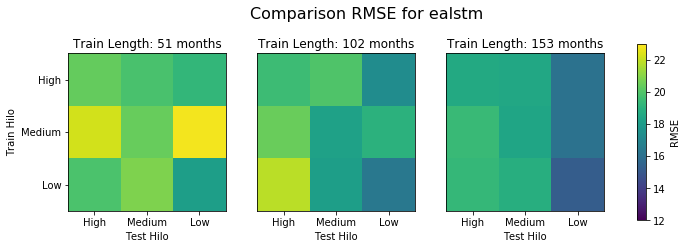

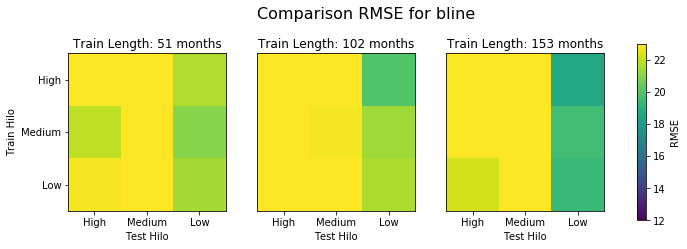

In [350]:
# plot matrices
model = 'ealstm'
kwargs = dict(vmin=12, vmax=23)
value_df = mean_rmse_df

def plot_experiment_matrices(value_df: pd.DataFrame, model: str, value: str = 'RMSE', **kwargs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    train_lengths = [51, 102, 153]  # df.train_length.unique()

    for ix, train_length in enumerate(train_lengths):
        ax_ix = np.unravel_index(ix, (3,))
        ax = axs[ax_ix]
        im = ax.imshow(
            value_df
            .query(f'model == "{model}_pred" & train_length == {train_length}')
            .drop(columns=['experiment', 'model', 'train_length'])
            .set_index(['test_hilo', 'train_hilo'])
            .values.reshape(3,3),
            **kwargs
        )

        ax.set_title(f'Train Length: {train_length} months')
        ax.set_xlabel('Test Hilo')
        ax.set_xticks(np.arange(0, 3))
        ax.set_xticklabels(['High', 'Medium', 'Low'])

        if ax_ix == (0, ):
            ax.set_ylabel('Train Hilo')
            ax.set_yticks(np.arange(0, 3))
            ax.set_yticklabels(['High', 'Medium', 'Low'])
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_yticklabels([])

    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.65)
    cbar.set_label(value)
    fig.suptitle(f'Comparison {value} for {model}', y=0.85, x=0.47, fontsize=16);
    

plot_experiment_matrices(value_df, model, value='RMSE', **kwargs)
plot_experiment_matrices(value_df, model='bline', value='RMSE', **kwargs)

* It looks like the LOWER test periods are MORE PERSISTENT (so poor vegetation conditions follow on from other poor vegetation conditions)
* This means that this is inherently easier to predict (?)
* We need to compare our results to 

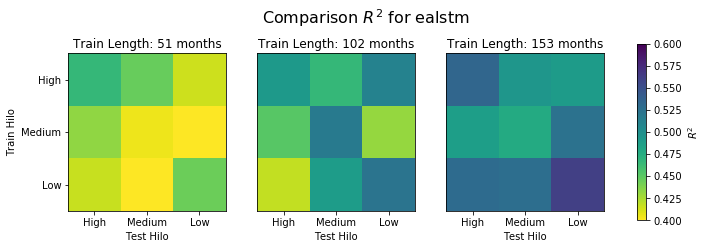

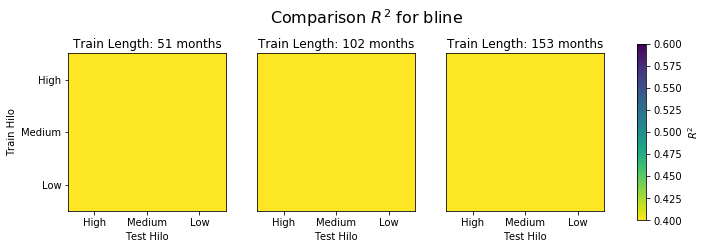

In [348]:
# plot matrices
model = 'ealstm'
kwargs = dict(vmin=0.4, vmax=0.6, cmap='viridis_r')
plot_experiment_matrices(mean_r2_df, model, value='$R^2$', **kwargs)

plot_experiment_matrices(mean_r2_df, model='bline', value='$R^2$', **kwargs)

# TODO: calculate the difference from Persistence

In [336]:
# experiment = experiments[0]
diff_rmse_dict = {}
diff_r2_dict = {}

for experiment in experiments:
    diff_rmse_dict[experiment] = {}
    diff_r2_dict[experiment] = {}

    for model in [k for k in rmse_dict[experiment].keys() if k != "bline_pred"]:
        model_rmse_diff = rmse_dict[experiment]['bline_pred'] - rmse_dict[experiment][model]
        model_r2_diff = r2_dict[experiment][model] - r2_dict[experiment]['bline_pred']

        diff_rmse_dict[experiment][model] = model_rmse_diff
        diff_r2_dict[experiment][model] = model_r2_diff

In [337]:
# -------- RMSE ---------
models_list, experiments_list, all_rmse_diffs = dict_to_arrays(diff_rmse_dict)
rmse_diff_means = [rmse_diff.compute().mean().values for rmse_diff in all_rmse_diffs]

# create dataframe
mean_rmse_diff_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=rmse_diff_means
)

# -------- R2 ---------
models_list, experiments_list, all_r2_diffs = dict_to_arrays(diff_r2_dict)
r2_diff_means = [r2_diff.compute().mean().values for r2_diff in all_r2_diffs]

# create dataframe
mean_r2_diff_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=r2_diff_means,
    col_name='R2'
)

display(mean_rmse_diff_df.head())
display(mean_r2_diff_df.head())

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,4.433786
1,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,5.452012
2,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,5.326281
3,one_month_forecast_TRhigh_TEhigh_LEN102,ealstm_pred,high,high,102,4.651533
4,one_month_forecast_TRhigh_TEhigh_LEN153,lstm_pred,high,high,153,7.841748


,experiment,model,test_hilo,train_hilo,train_length,R2
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,0.304627
1,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,0.345134
2,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,0.328160
3,one_month_forecast_TRhigh_TEhigh_LEN102,ealstm_pred,high,high,102,0.296869
4,one_month_forecast_TRhigh_TEhigh_LEN153,lstm_pred,high,high,153,0.465420


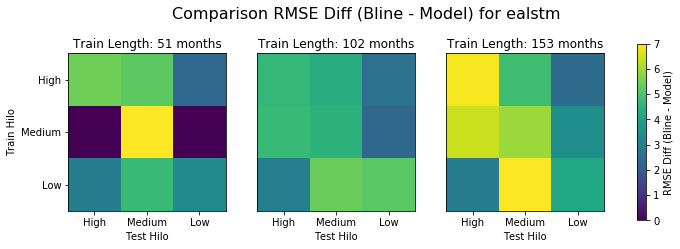

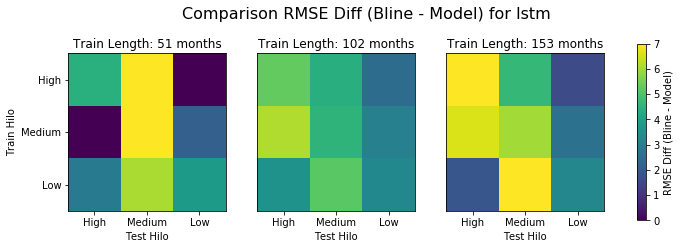

In [345]:
model = 'ealstm'
kwargs = dict(vmin=0, vmax=7)
plot_experiment_matrices(mean_rmse_diff_df, model, value='RMSE Diff (Bline - Model)', **kwargs)

model = 'lstm'
plot_experiment_matrices(mean_rmse_diff_df, model, value='RMSE Diff (Bline - Model)', **kwargs)

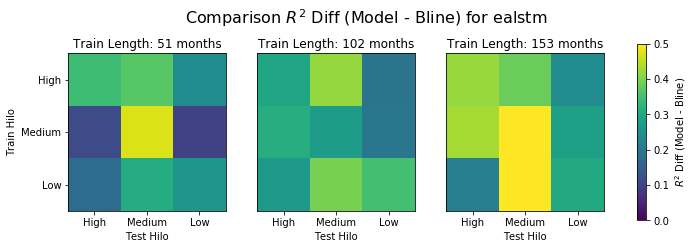

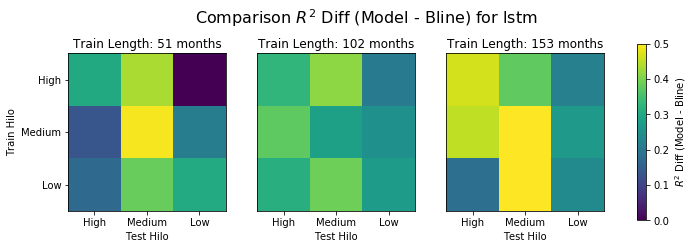

In [343]:
model = 'ealstm'
kwargs = dict(vmin=0, vmax=0.5)
plot_experiment_matrices(mean_r2_diff_df, model, value='$R^2$ Diff (Model - Bline)', **kwargs)

model = 'lstm'
kwargs = dict(vmin=0, vmax=0.5)
plot_experiment_matrices(mean_r2_diff_df, model, value='$R^2$ Diff (Model - Bline)', **kwargs)

## Interpretation
* We seem to perform best (RMSE) on the LOW test period VCI values (i.e. in drought conditions)
* Our performance does improve as the training period gets longer

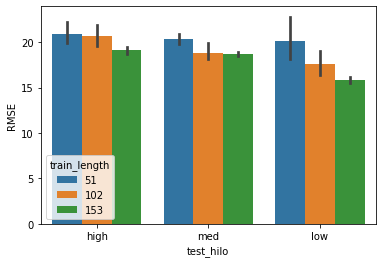

In [166]:
sns.barplot(
    x='test_hilo', hue='train_length', y='RMSE', 
    data=mean_rmse_df.query('model == "ealstm_pred"')
)

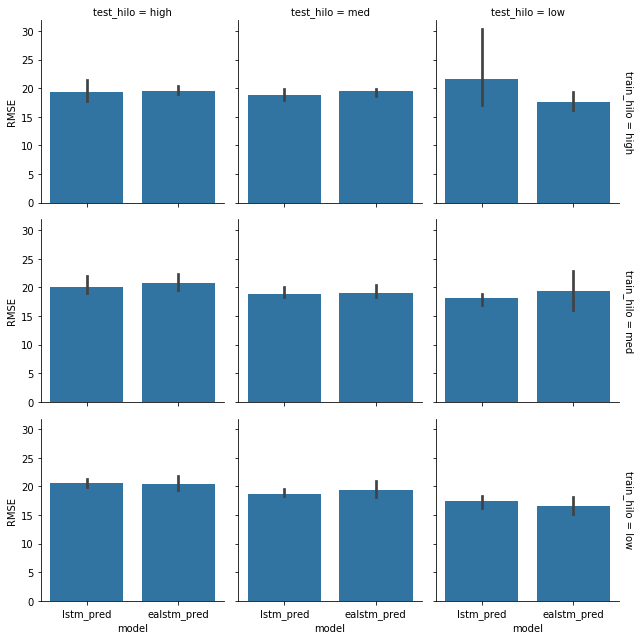

In [172]:
plot_df = mean_rmse_df.query(" model == 'ealstm_pred' | model == 'lstm_pred' ")
g = sns.FacetGrid(plot_df, row="train_hilo", col="test_hilo", margin_titles=True)
g.map(sns.barplot, 'model', 'RMSE')

### High Level Overview
* low, med, high train lengths
* 3x3 matrices of (test_hilo vs. train_hilo) 
* expect to see better performance on the 1:1 line

In [ ]:
dict_ = {}

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        model_rmse = rmse_dict[experiment_name][model]
        dict_[f"{experiment_name}_{model}"] = [np.nanmean(model_rmse.values)]


fig, ax = plt.subplots(figsize=(12, 5))
mean_df = pd.DataFrame(dict_).T.astype(float)
mean_df.plot.bar(ax=ax, legend=False)

ax.set_title('Experiment Comparison: RMSE')
ax.set_ylabel('Mean RMSE');
plt.xticks(rotation=45)

# 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3), p.get_height() * 1.05),  # (x, y) coords
        fontsize=12,
#         fontweight='bold'
    )

## Experiment Parameters
- **Train Length** = short, medium, long
- **Test VCI** = low, medium, high
- **Train VCI** = low, medium, high

#### Hypotheses
* The model performance will improve as the train length gets longer (more data)
* The model will perform better when it is trained on a similar regime to the testing regime (high-high, low-low [TR:TE])
* The model performance will change gradually (better for medium-low than high-low [TR:TE])